# Análisis de los grafos resultantes

## Carga de librerías necesarias

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import leidenalg as la
import random

from scipy.io import mmread
from networkx.algorithms.community import modularity

## Funciones

In [2]:
def plot_graph(G):
    # --- Posicionamiento ---
    pos = nx.kamada_kawai_layout(G)
    
    # --- Dibujar ---
    plt.figure(figsize=(8, 6))
    nx.draw(
        G,
        pos,
        node_size=50,
        edge_color='lightgrey',
        width=1,
        with_labels=False,
        arrows=True,
        arrowsize=4
    )
    plt.show()

In [3]:
def plot_and_get_strong_component(G):
    """
    Dibuja y devuelve la mayor componente fuertemente conexa de G.
    """
    # Layout global sobre G
    pos = nx.kamada_kawai_layout(G)

    # Todas las componentes fuertes
    comps = list(nx.strongly_connected_components(G))
    print(f"Total de componentes fuertemente conexas: {len(comps)}")

    # Extraer la más grande
    Gc = G.subgraph(max(comps, key=len)).copy()
    print(f"Tamaño de la mayor componente fuertemente conexa: {Gc.number_of_nodes()} nodos")

    # Nodos de Gc
    nodes = list(Gc.nodes())

    # Dibujar
    plt.figure(figsize=(6, 5))
    nx.draw(
        Gc,
        {n: pos[n] for n in nodes},
        node_size=50,
        edge_color='lightgrey',
        width=1,
        with_labels=False,
        arrows=True,
        arrowsize=4
    )
    plt.title("Mayor componente fuertemente conexa")
    plt.show()

    return Gc

In [4]:
def generate_random_g_no_isolates(G, num_graphs=100):
    """
    Genera `num_graphs` réplicas dirigidas con |V| y |E| iguales a G,
    garantizando que ningún nodo quede aislado y sin muestreo por rechazo.
    """
    n_nodes = G.number_of_nodes()
    m_edges = G.number_of_edges()
    nodes = list(G.nodes())
    H = []
    
    if m_edges < n_nodes - 1:
        raise ValueError(
            "No es posible evitar todos los aislados cuando m < n-1."
        )
    
    for _ in range(num_graphs):
        # 1) Barajar nodos y crear un árbol dirigido de n-1 aristas
        random.shuffle(nodes)
        H_i = nx.DiGraph()
        H_i.add_nodes_from(nodes)
        for j in range(1, n_nodes):
            u = random.choice(nodes[:j])
            v = nodes[j]
            H_i.add_edge(u, v)
        
        # 2) Añadir las aristas restantes de forma uniforme
        remaining = m_edges - (n_nodes - 1)
        # todos los pares posibles sin self‑loops ni las del árbol
        posibles = [
            (u, v)
            for u in nodes for v in nodes
            if u != v and not H_i.has_edge(u, v)
        ]
        extras = random.sample(posibles, remaining)
        H_i.add_edges_from(extras)
        
        H.append(H_i)
    
    return H

In [5]:
def _nx_to_igraph(G):
    idx = {n: i for i, n in enumerate(G.nodes())}
    g   = ig.Graph(edges=[(idx[u], idx[v]) for u, v in G.edges()],
                   directed=False)
    g.vs["name"] = list(G.nodes())
    inv = {i: n for n, i in idx.items()}
    return g, inv

def detect_leiden(G, seed=42):
    G_und = G.to_undirected()
    g_ig, inv = _nx_to_igraph(G_und)
    part = la.find_partition(g_ig, la.ModularityVertexPartition, seed=seed)
    comms = [ {inv[v] for v in cluster} for cluster in part ]
    mod = part.modularity
    return comms, mod

In [6]:
def detect_and_plot_communities(G, modularity_threshold=0.3, seed=42, verbose=True, plot=True):
    """Detecta comunidades en versión no‑dirigida de un grafo G"""
    # Convertir a no dirigido y detectar comunidades
    G_und = G.to_undirected()
    communities, mod_score = detect_leiden(G, seed=seed)
    
    # Calcular modularidad global
    mod_score = modularity(G_und, communities)
    status = "Alta" if mod_score > modularity_threshold else "Baja"
    if verbose:
        print(f"Modularidad global: {mod_score:.3f} → {status}")
        print(f"Se detectaron {len(communities)} comunidades:")
        for i, comm in enumerate(communities):
            print(f"  - Comunidad {i}: {len(comm)} nodos")
    else:
        return len(communities), mod_score, status

    if plot:
        # Asignar un color a cada comunidad
        cmap = plt.cm.tab20
        color_map = {}
        for i, comm in enumerate(communities):
            color = cmap(i % cmap.N)
            for node in comm:
                color_map[node] = color
    
        # Construir lista de colores en el orden de G.nodes()
        node_colors = [color_map[n] for n in G.nodes()]
    
        # 1) Construir la matriz dist:
        dist = {u: {} for u in G.nodes()}
        for u in G.nodes():
            for v in G.nodes():
                if u == v:
                    dist[u][v] = 0
                # misma comunidad → distancia baja
                elif any(u in comm and v in comm for comm in communities):
                    dist[u][v] = 1
                # distinta comunidad → distancia alta
                else:
                    dist[u][v] = 10
        
        # Posiciones
        pos = nx.kamada_kawai_layout(G, dist=dist)
    
        # Dibujar
        plt.figure(figsize=(8, 6))
        nx.draw(
            G,
            pos,
            node_size=50,
            node_color=node_colors,
            edge_color='lightgrey',
            width=1,
            with_labels=False,
            arrows=True,
            arrowsize=4
        )
        plt.title("Comunidades")
        plt.show()

In [7]:
def graph_features(G):
    # Convertimos a no‑dirigido y extraemos métricas
    G_und = G.to_undirected()
    comps = list(nx.connected_components(G_und))
    num_comps = len(comps)
    
    # Parámetros básicos
    n = G_und.number_of_nodes()
    m = G_und.number_of_edges()
    
    # Cálculo del grado medio: 
    avg_degree = (2 * m / n) if n > 0 else 0
    
    return {
        'kemeny_constant': nx.kemeny_constant(G_und),
        'transitivity': nx.transitivity(G_und),
        'avg_shortest_path': nx.average_shortest_path_length(G_und),
        'diameter': nx.diameter(G_und),
        'avg_degree': np.mean([d for _, d in G_und.degree()])
    }

In [8]:
def calcular_aristas(n1, m1, n2, dirigido_original=False, dirigido_nuevo=False, redondear=True):
    """
    Calcula el número de aristas m2 para un grafo de n2 nodos
    de modo que conserve la misma densidad que un grafo original
    de n1 nodos y m1 aristas.

    Parámetros:
    - n1 (int): nodos del grafo original.
    - m1 (int): aristas del grafo original.
    - n2 (int): nodos del nuevo grafo.
    - dirigido_original (bool): True si el grafo original es dirigido; False si es no dirigido.
    - dirigido_nuevo (bool): True si el nuevo grafo es dirigido; False si es no dirigido.
    - redondear (bool): True para devolver un entero; False para float.

    Retorna:
    - int o float: número de aristas necesarias en el nuevo grafo.
    """
    # Determina pares posibles en el original
    if dirigido_original:
        pares1 = n1 * (n1 - 1)
    else:
        pares1 = n1 * (n1 - 1) / 2

    # Determina pares posibles en el nuevo
    if dirigido_nuevo:
        pares2 = n2 * (n2 - 1)
    else:
        pares2 = n2 * (n2 - 1) / 2

    densidad = m1 / pares1
    m2 = densidad * pares2

    return int(round(m2)) if redondear else m2

## Grafo de Retweets

In [ ]:
# Carga la matriz sparse y construye el grafo dirigido
mat = mmread('../data/rt-retweet.mtx')
G_rt = nx.DiGraph(mat)

Total de componentes fuertemente conexas: 1
Tamaño de la mayor componente fuertemente conexa: 96 nodos


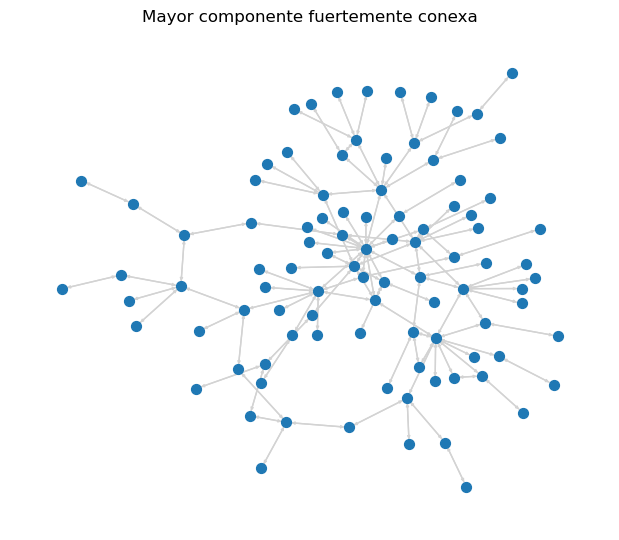

In [10]:
# 1a componente conexa
G_rt_strong = plot_and_get_strong_component(G_rt)

## Grafo generado con Exponencial y p_value_cutoff = 0.05

In [ ]:
# Leer el CSV exportado
df_exp_p05 = pd.read_csv('../data/result_graph_exp_p05.csv')

In [12]:
G = nx.from_pandas_edgelist(
    df_exp_p05,
    source='origin_node',
    target='destination_node',
    edge_attr=True,
    create_using=nx.DiGraph()
)

In [13]:
print(f"Nº de nodos del grafo de NetInf: {G.number_of_nodes()}")
print(f"Nº de ejes del grafo de NetInf: {G.number_of_edges()}")

Nº de nodos del grafo de NetInf: 338
Nº de ejes del grafo de NetInf: 541


### Visualización

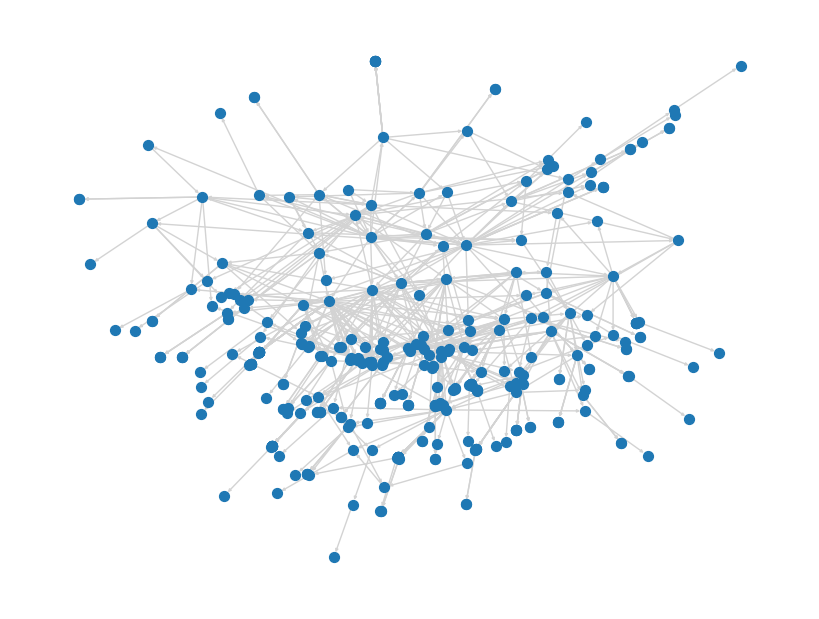

In [14]:
plot_graph(G)

Total de componentes fuertemente conexas: 313
Tamaño de la mayor componente fuertemente conexa: 26 nodos


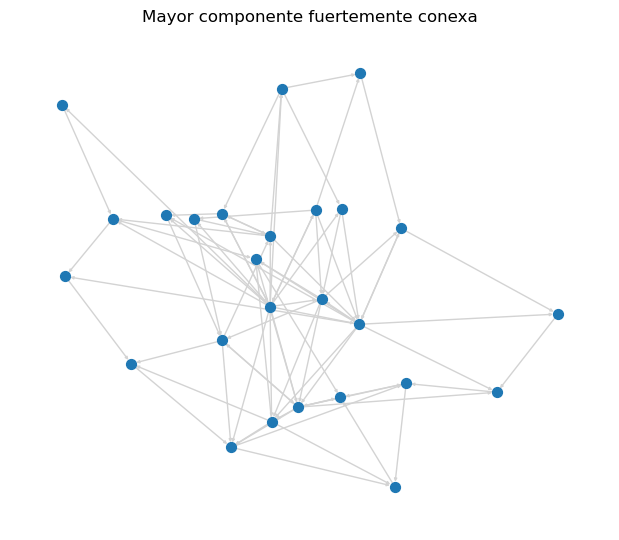

In [15]:
# 1a componente fuertemente conexa
G_strong = plot_and_get_strong_component(G)

### Comparativa con grafo de Retweets

Veamos la diferencia en la densidad de ambos.

In [16]:
print(f"Densidad del grafo Netinf: {nx.density(G)}")
print(f"Densidad del grafo de Retweets: {nx.density(G_rt)}")

Densidad del grafo Netinf: 0.004749530314469826
Densidad del grafo de Retweets: 0.025657894736842105


In [17]:
print(f"Densidad 1a componente conexa Netinf: {nx.density(G_strong)}")
print(f"Densidad 1a componente conexa Retweets: {nx.density(G_rt_strong)}")

Densidad 1a componente conexa Netinf: 0.12307692307692308
Densidad 1a componente conexa Retweets: 0.025657894736842105


#### Estructura de comunidades

Modularidad global: 0.680 → Alta
Se detectaron 8 comunidades:
  - Comunidad 0: 16 nodos
  - Comunidad 1: 15 nodos
  - Comunidad 2: 13 nodos
  - Comunidad 3: 12 nodos
  - Comunidad 4: 12 nodos
  - Comunidad 5: 12 nodos
  - Comunidad 6: 11 nodos
  - Comunidad 7: 5 nodos


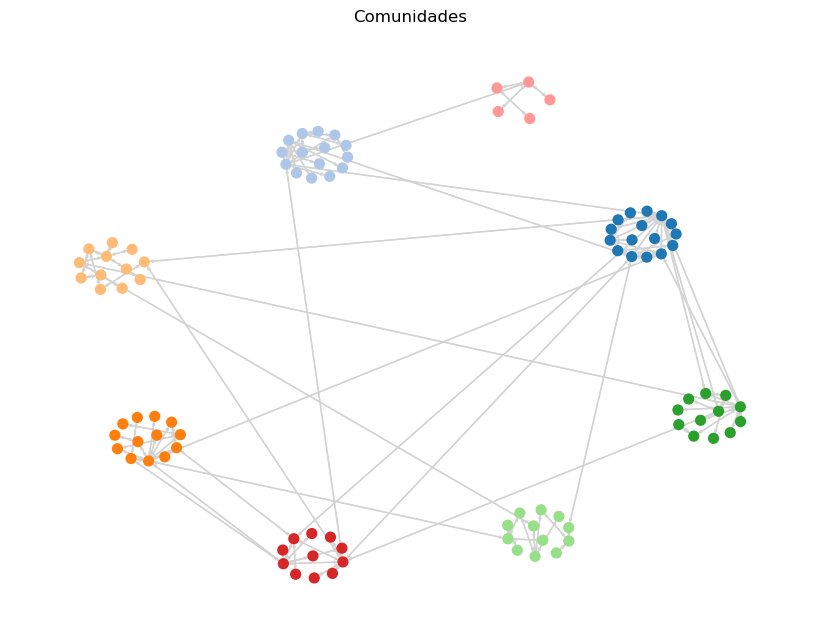

In [18]:
# Estructura de comunidades en grafo de Retweets
detect_and_plot_communities(G_rt_strong)

Modularidad global: 0.636 → Alta
Se detectaron 11 comunidades:
  - Comunidad 0: 48 nodos
  - Comunidad 1: 47 nodos
  - Comunidad 2: 45 nodos
  - Comunidad 3: 43 nodos
  - Comunidad 4: 38 nodos
  - Comunidad 5: 34 nodos
  - Comunidad 6: 31 nodos
  - Comunidad 7: 21 nodos
  - Comunidad 8: 18 nodos
  - Comunidad 9: 9 nodos
  - Comunidad 10: 4 nodos


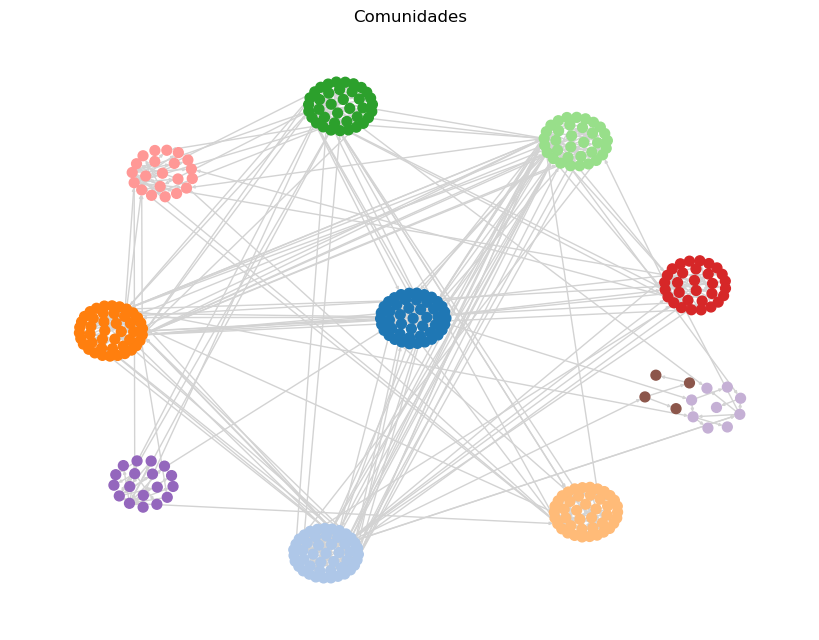

In [19]:
# Estructura de comunidades en grafo Netinf
detect_and_plot_communities(G)

#### Métricas

In [20]:
feat_g = graph_features(G_rt_strong)

In [21]:
df_metrics_rt = pd.DataFrame(feat_g, index=['Retweets'])
df_metrics_rt

,kemeny_constant,transitivity,avg_shortest_path,diameter,avg_degree
Retweets,210.23679,0.074227,4.310526,10,2.4375


In [22]:
feat_g = graph_features(G)

In [23]:
df_metrics_g = pd.DataFrame(feat_g, index=['MiRed'])
df_metrics_g

,kemeny_constant,transitivity,avg_shortest_path,diameter,avg_degree
MiRed,514.045524,0.065897,4.020473,9,3.16568


### Comparativa con grafos aleatorios con mismo nº de nodos y ejes

In [24]:
G_rand_list = generate_random_g_no_isolates(G)

#### Métricas

In [25]:
feat_g = graph_features(G)

In [26]:
df_metrics = pd.DataFrame(feat_g, index=['MiRed'])
df_metrics

,kemeny_constant,transitivity,avg_shortest_path,diameter,avg_degree
MiRed,514.045524,0.065897,4.020473,9,3.16568


In [27]:
feat_g_rand = []
for g_rand in G_rand_list:
    feat_g_rand.append(graph_features(g_rand))

df_metrics_g_rand = pd.DataFrame(feat_g_rand)
df_metrics_g_rand.head()

,kemeny_constant,transitivity,avg_shortest_path,diameter,avg_degree
0,594.292689,0.005357,5.094534,11,3.201183
1,584.311082,0.005187,4.964462,10,3.195266
2,583.362282,0.007059,5.051147,10,3.201183
3,591.193656,0.005332,5.108704,11,3.201183
4,597.237389,0.003456,5.080856,12,3.189349


In [28]:
df_metrics_g_rand.describe()

,kemeny_constant,transitivity,avg_shortest_path,diameter,avg_degree
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,593.394865,0.007383,5.082488,10.730000,3.196331
std,7.354486,0.003561,0.058708,0.694204,0.005073
min,576.429584,0.000000,4.943462,9.000000,3.183432
25%,588.400535,0.005255,5.041877,10.000000,3.195266
50%,593.539096,0.007184,5.080022,11.000000,3.195266
75%,597.318971,0.008899,5.116184,11.000000,3.201183
max,612.402030,0.018922,5.244658,12.000000,3.201183


## Grafo generado con Exponencial y $n\_edges$ que imite la densidad del grafo de Retweets

In [29]:
print(f"Densidad del grafo de Retweets: {nx.density(G_rt)}")

Densidad del grafo de Retweets: 0.025657894736842105


In [30]:
print(f"Nº de nodos del grafo de Retweets: {G_rt.number_of_nodes()}")
print(f"Nº de ejes del grafo de Retweets: {G_rt.number_of_edges()}")

Nº de nodos del grafo de Retweets: 96
Nº de ejes del grafo de Retweets: 234


In [ ]:
df_netinf = pd.read_csv('../data/netinf_data.csv')
n_original_nodes = df_netinf.node_name.nunique()
print(f"Nº de canales inicial en los datos: {n_original_nodes}")

Nº de canales inicial en los datos: 401


In [32]:
n1, m1 = G_rt.number_of_nodes(), G_rt.number_of_edges()  # grafo retweets
n2 = n_original_nodes
resultado = calcular_aristas(
    n1, m1, n2,
    dirigido_original=False,
    dirigido_nuevo=True
)
print(f"Aristas para densidad igual: {resultado}")

Aristas para densidad igual: 8231


In [ ]:
# Leer el CSV exportado
df_exp_nedges = pd.read_csv('../data/result_graph_nedges.csv')

In [34]:
G = nx.from_pandas_edgelist(
    df_exp_nedges,
    source='origin_node',
    target='destination_node',
    edge_attr=True,
    create_using=nx.DiGraph()
)

In [35]:
print(f"Nº de nodos en el nuevo grafo de NetInf: {G.number_of_nodes()}")
print(f"Nº de ejes en el nuevo grafo de NetInf: {G.number_of_edges()}")

Nº de nodos en el nuevo grafo de NetInf: 401
Nº de ejes en el nuevo grafo de NetInf: 8231


### Visualización

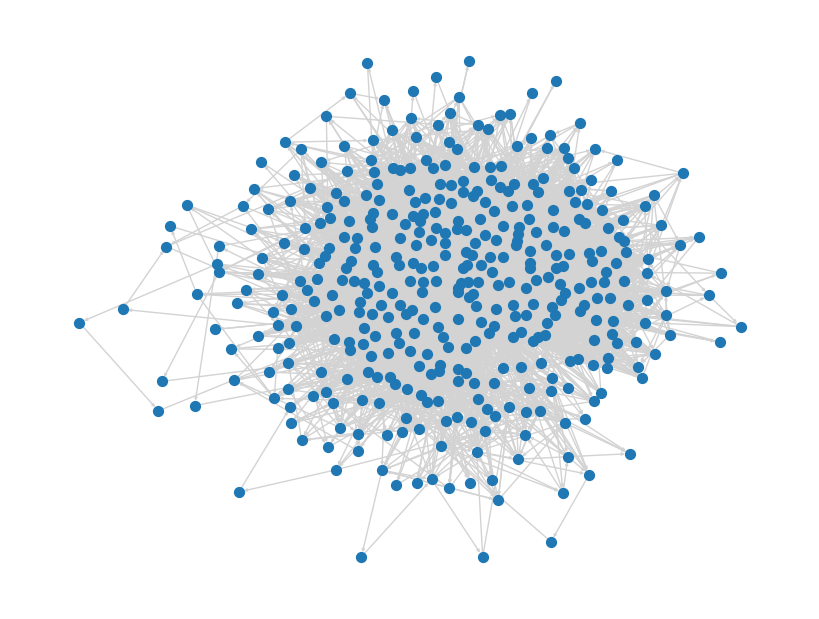

In [36]:
plot_graph(G)

Total de componentes fuertemente conexas: 5
Tamaño de la mayor componente fuertemente conexa: 397 nodos


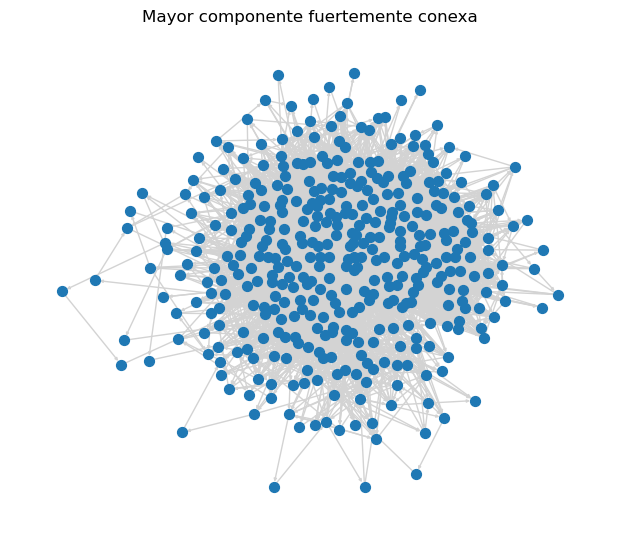

In [37]:
# 1a componente fuertemente conexa
G_strong = plot_and_get_strong_component(G)

## Comparativa con grafo de Retweets

Veamos la diferencia en la densidad de ambos.

In [38]:
print(f"Densidad nuevo grafo Netinf: {nx.density(G)}")
print(f"Densidad grafo Retweets: {nx.density(G_rt)}")

Densidad nuevo grafo Netinf: 0.051315461346633416
Densidad grafo Retweets: 0.025657894736842105


In [39]:
print(f"Densidad 1a componente conexa nuevo grafo Netinf: {nx.density(G_strong)}")
print(f"Densidad 1a componente conexa Retweets: {nx.density(G_rt_strong)}")

Densidad 1a componente conexa nuevo grafo Netinf: 0.050123400249344835
Densidad 1a componente conexa Retweets: 0.025657894736842105


#### Estructura de comunidades

Modularidad global: 0.254 → Baja
Se detectaron 5 comunidades:
  - Comunidad 0: 122 nodos
  - Comunidad 1: 96 nodos
  - Comunidad 2: 94 nodos
  - Comunidad 3: 57 nodos
  - Comunidad 4: 32 nodos


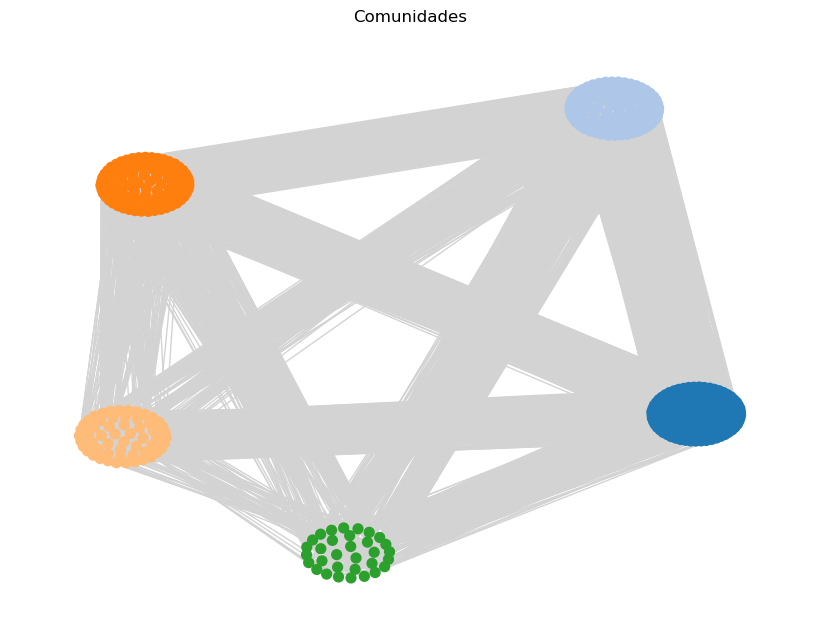

In [40]:
# Estructura de comunidades en grafo Netinf
detect_and_plot_communities(G)

## Comparativa con grafo aleatorio con mismo nº de nodos y ejes

In [41]:
G_rand_list = generate_random_g_no_isolates(G)

#### Métricas

In [42]:
feat_g  = graph_features(G)

In [43]:
df_metrics = pd.DataFrame(feat_g, index=['MiRed'])
df_metrics

,kemeny_constant,transitivity,avg_shortest_path,diameter,avg_degree
MiRed,415.089667,0.319105,2.156446,5,37.800499


In [44]:
feat_g_rand = []
for g_rand in G_rand_list:
    feat_g_rand.append(graph_features(g_rand))

df_metrics_g_rand = pd.DataFrame(feat_g_rand)
df_metrics_g_rand.head()

,kemeny_constant,transitivity,avg_shortest_path,diameter,avg_degree
0,408.391259,0.100465,1.915998,3,39.945137
1,408.377059,0.099727,1.917531,3,39.985037
2,408.338308,0.099913,1.915212,3,40.099751
3,408.361874,0.100938,1.915960,3,40.089776
4,408.361866,0.099408,1.916372,3,40.029925


In [45]:
df_metrics_g_rand.describe()

,kemeny_constant,transitivity,avg_shortest_path,diameter,avg_degree
count,100.000000,100.000000,100.000000,100.0,100.000000
mean,408.379804,0.099984,1.916350,3.0,39.998953
std,0.018928,0.000866,0.000754,0.0,0.063125
min,408.338308,0.097746,1.914651,3.0,39.805486
25%,408.366337,0.099456,1.915795,3.0,39.952618
50%,408.378702,0.100100,1.916340,3.0,40.004988
75%,408.393973,0.100610,1.916923,3.0,40.044888
max,408.427740,0.101704,1.917955,3.0,40.119701
